In [2]:
PROJECT_LINK = 'assignment7'
PATH = '/Users/touchpadthamkul/zatoDev/project/bads_crm_final/master/BADS7105'


# FRAMEWORK
from IPython.display import Markdown as md
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import datetime, pytz
import numpy as np
import os

pio.renderers.default = 'colab'

def getVariableNames(variable):
    results = []
    globalVariables=globals().copy()
    for globalVariable in globalVariables:
        if id(variable) == id(globalVariables[globalVariable]):
            results.append(globalVariable)
    return results

def displayPlot(fig):
    project_id = PROJECT_LINK.replace(' ','_')
    fig_json = fig.to_json()
    fig_name = str(datetime.datetime.now(tz=pytz.timezone('Asia/Bangkok')).date())+'-'+project_id+'_'+getVariableNames(fig)[0]
    filename = fig_name+'.html'
    if PATH != '':
        save_path = PATH + '/_includes/post-figures/'
    else:
        save_path = ''
    completeName = os.path.join(save_path, filename)
    template = """
<html>
    <head>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    </head>
    <body>
        <div id='{1}'></div>
        <script>
            var plotly_data = {0};
            let config = {{displayModeBar: false }};
            Plotly.react('{1}', plotly_data.data, plotly_data.layout, config);
        </script>
    </body>
</html>
"""
    # write the JSON to the HTML template
    with open(completeName, 'w') as f:
        f.write(template.format(fig_json, fig_name))
    return md("{% include post-figures/" + filename + " full_width=true %}")

def displayImg(img_name):
    master_name = str(datetime.datetime.now(tz=pytz.timezone('Asia/Bangkok')).date()) + '-' + PROJECT_LINK + '-' + img_name
    !cp -frp $img_name $master_name
    if PATH != '':     
        img_path = PATH + '/images/projects'
        !mv $master_name $img_path
        output = md("![](/BADS7105/images/projects/" + master_name +")")
    else:
        img_path = PATH
        output = md("![]("+master_name +")")
    return output


from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

def runBrowser(url):
    url = 'https://zato.dev/blog/' + PROJECT_LINK
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("window-size=375,812")
    # browser = webdriver.Chrome('/Users/touchpadthamkul/PySelenium/chromedriver', chrome_options=chrome_options)
    browser = webdriver.Chrome(ChromeDriverManager().install(),chrome_options=chrome_options)
    browser.get(url)

    
import ipynbname

def saveExport():        
    pynb_name = ipynbname.name() +'.ipynb'
    md_name = ipynbname.name() +'.md'
    if PATH != '':
        selected = int(input('1 posts \n2 projects\n'))
        if selected != 1:
            folder = '/_projects'
        else:
            folder = '/_posts'
        post_path = PATH + folder
    else:
        post_path = ''
    master_name = str(datetime.datetime.now(tz=pytz.timezone('Asia/Bangkok')).date()) + '-' + PROJECT_LINK + '.md'
    !jupyter nbconvert --to markdown $pynb_name
    !mv $md_name $master_name
    !mv $master_name $post_path

# saveExport()
# runBrowser(url)

In [111]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


ก่อนจะสร้างโมเดล Natural Language Processing (NLP) ต้องทำ Text Embedding เพื่อแปลงจากตัวอักษร เป็นตัวเลข เพื่อให้คอมพิวเตอร์เข้าใจภาษามนุย์ โดยเราจะทำการใช้ Google's Universal Sentence Encoder เพื่อใช้ฟังก์ชันเปลี่ยนตัวอักษรเป็นตัวเลข

In [112]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

ดึงข้อมูลรีวิวจาก Wongnai ทั้งหมดทั้งหมด 300 รีวิว

In [113]:
df = pd.read_csv('Wongnai Reviews - Small.csv')
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review ID  300 non-null    int64 
 1   Review     300 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.8+ KB


### Step1 - document embedding and dimension reduction

In [115]:
#embed sentences using Universal Sentence Encoder (USE)
#reduce array dimensions using umap (you can chagne n_components)

embed_comments_array = model(df['Review'].values).numpy()
reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

umap_embed_comments_array

array([[4.38797  , 7.3366637, 4.3473525, ..., 5.737648 , 4.4198318,
        5.942006 ],
       [4.5256295, 7.3365474, 4.4462757, ..., 5.623406 , 4.375579 ,
        5.9466367],
       [5.2760754, 6.866459 , 3.9091702, ..., 5.8130536, 4.945471 ,
        5.4968505],
       ...,
       [4.4710193, 6.991462 , 4.4716787, ..., 5.644046 , 4.444365 ,
        5.9356337],
       [4.4344482, 7.070292 , 4.534156 , ..., 5.6133623, 4.41475  ,
        5.9124784],
       [4.376653 , 7.1932964, 4.4902244, ..., 5.676849 , 4.370813 ,
        5.965906 ]], dtype=float32)

### Step 2 - document clustering using KMeans

Text(0, 0.5, 'WCSS')

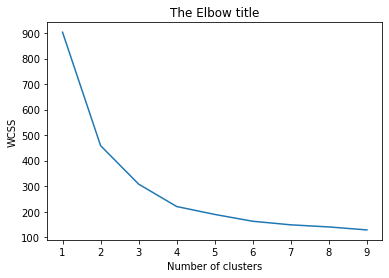

In [116]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [117]:
#run kmeans with no. of clusters you see fit the most

k = 3

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row
    
df_kmeans

,KMeans ID,texts
0,0,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...


สร้างคำ และแพทเทิร์นที่ต้องการยกเว้น

In [118]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"
specialchar_pattern = re.compile(special_characters)

#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [119]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', 'ทาน', 'กิน']
screening_words = stopwords + removed_words

new_words = {"สตารบัก"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [120]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [121]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (เครื่องดื่..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คว...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 14), (อร่อย, 11), (กก, 10), (อาหา..."
2,2,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, Macchiato, เป็นประจำ, นึง, เด, Artof...","[(ร้านกาแฟ, 26), (กาแฟ, 23), (ชอบ, 11), (คาเฟ่..."


In [124]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('เครื่องดื่ม', 4), ('ร้า', 3), ('น้ำ', 3), ('ตั้งอยู่', 3), ('ลอง', 3), ('เดิน', 3), ('ปั่น', 3)]

Cluster ID : 1

Most common words include : [('ร้านอาหาร', 14), ('อร่อย', 11), ('กก', 10), ('อาหาร', 9), ('รีวิว', 7), ('บ้าน', 6), ('ส้มตำ', 6), ('ซอย', 6), ('สาขา', 6), ('เพื่อน', 5)]

Cluster ID : 2

Most common words include : [('ร้านกาแฟ', 26), ('กาแฟ', 23), ('ชอบ', 11), ('คาเฟ่', 6), ('น', 6), ('รีวิว', 6), ('แวะ', 6), ('ดี', 6), ('รี่', 5), ('อร่อย', 5)]



## Step 3 - Result Discussion

### Cluster 0 : ร้านกาแฟ และ คาเฟ่
คำใกล้เคียง :
-  ('ร้านกาแฟ', 25)
-  ('กาแฟ', 23)
-  ('ชอบ', 11)
-  ('คาเฟ่', 6)
-  ('น', 6)
-  ('แวะ', 6)
-  ('ดี', 6)
-  ('รี่', 5)
-  ('อร่อย', 5)
-  ('น่ารัก', 5)

In [123]:
df[df["KMeans ID"] == 0].Review

13     เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่อให้อิ่...
20     เช้าๆบ่ายๆหรือเย็นๆ อาหารว่างที่คนเรามักหยิบจั...
23     ระหว่างมุ่งหน้าสู่ชัยภูมิ เราแวะเติมพลังกันที่...
29     เป็นร้านเครื่องดื่มขนาดกระทัดรัด พื้นที่น้อย เ...
30     ร้านขายเครื่องดื่มผลิตภัณฑ์ชาเขียว ไอศรีมชาเขี...
31     ชานมไข่มุก จริงๆคืออ้วนมาก\nไม่ค่อยอยากกินเลย\...
34     เดินผ่านร้านนี้มาหลายครั้งแล้วค่ะ สังเกตว่าร้า...
42     ร้านอยู่โซนซุ้มขายของเล็กๆตรงกลางนะคะ ใกล้ๆกับ...
44     บนห้าง Big-C ราชดำริ นิวคุงได้ไปเจอร้านขายน้ำท...
47     ...น่าจะใช่นะ Ochaya มีสาขาเยอะมากๆทั้งตึกออฟฟ...
58     ร้าน April store เป็นร้านกาแฟขนาดเล็ก ตั้งอยู่...
61     วันนี้มาเดินเที่ยวสยามคะ ถ้าชาไข่มุกอร่อยๆต้อง...
66     ร้าน April store อยู่บริเวณสวนของ ยู เซ็นเตอร์...
74     วันก่อนนิวคุงไปเดินเล่นหาอะไรกินในย่านหอการค้า...
84     วันนี้ได้ฤกษ์มารีวิวร้านชานมไข่มุก ร้านที่โปรด...
87     เป็นคนชอบทานชาไข่มุก ลองมาแล้วหลายร้าน ติดใจรส...
90     ร้าน A Little Sweet เป็นร้านของหวานสไตล์ desse...
93     \n\n\n\n\nร้าน Dakasi เป

### Cluster 1 : ร้านอาหาร
คำใกล้เคียง
-  ('ร้านอาหาร', 14)
-  ('อร่อย', 11)
-  ('อาหาร', 9)
-  ('รีวิว', 7)
-  ('บ้าน', 6)
-  ('ส้มตำ', 6)
-  ('ซอย', 6)
-  ('สาขา', 6)
-  ('เพื่อน', 5)

In [107]:
df[df["KMeans ID"] == 1].Review

2      กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3      วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4      ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...
6      สวัสดีเพื่อนๆสมาชิกนักรีวิวร้านอาหารชาว Wongna...
9      ร้านส้มตำเจ๊พิมอยู่ถนนเลี่ยงตลาดหนองมน\nเป็นร้...
                             ...                        
286    สวัสดีค่ะ ชื่อร้านนี้อาจจะน่ากลัวสักหน่อยนะคะ ...
289    อร่อยดีครับ เพิ่งมาครั้งแรกขับรถหลงๆ มาเห็นร้า...
291    ร้านนี้เป็นหนึ่งในความตั้งใจว่า อยากจะทำเรื่อง...
293    ร้านนี้หาไม่ยากครับ อยู่ที่ปากซอย6 ถนนนิมมาน \...
295    ค่ำนี้คุณเพื่อนอยากส้มตำ หมูเฮาเลยพากันลงมากิน...
Name: Review, Length: 118, dtype: object

## Cluster 2 : ร้านชานมไข่มุก
คำใกล้เคียง
- ('ชา', 18)
-  ('นม', 14)
-  ('ไข่มุก', 14)
-  ('เครื่องดื่ม', 4)
-  ('รีวิว', 4)
-  ('ร้า', 3)
-  ('น้ำ', 3)
-  ('ตั้งอยู่', 3)
-  ('ลอง', 3)
-  ('เดิน', 3)

In [108]:
df[df["KMeans ID"] == 2].Review

13     เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่อให้อิ่...
19     ร้านกาแฟร้านนี้ เมื่อเข้าไปแล้วบรรยายกาศจะออกแ...
20     เช้าๆบ่ายๆหรือเย็นๆ อาหารว่างที่คนเรามักหยิบจั...
23     ระหว่างมุ่งหน้าสู่ชัยภูมิ เราแวะเติมพลังกันที่...
29     เป็นร้านเครื่องดื่มขนาดกระทัดรัด พื้นที่น้อย เ...
30     ร้านขายเครื่องดื่มผลิตภัณฑ์ชาเขียว ไอศรีมชาเขี...
31     ชานมไข่มุก จริงๆคืออ้วนมาก\nไม่ค่อยอยากกินเลย\...
34     เดินผ่านร้านนี้มาหลายครั้งแล้วค่ะ สังเกตว่าร้า...
42     ร้านอยู่โซนซุ้มขายของเล็กๆตรงกลางนะคะ ใกล้ๆกับ...
44     บนห้าง Big-C ราชดำริ นิวคุงได้ไปเจอร้านขายน้ำท...
47     ...น่าจะใช่นะ Ochaya มีสาขาเยอะมากๆทั้งตึกออฟฟ...
58     ร้าน April store เป็นร้านกาแฟขนาดเล็ก ตั้งอยู่...
61     วันนี้มาเดินเที่ยวสยามคะ ถ้าชาไข่มุกอร่อยๆต้อง...
66     ร้าน April store อยู่บริเวณสวนของ ยู เซ็นเตอร์...
74     วันก่อนนิวคุงไปเดินเล่นหาอะไรกินในย่านหอการค้า...
84     วันนี้ได้ฤกษ์มารีวิวร้านชานมไข่มุก ร้านที่โปรด...
87     เป็นคนชอบทานชาไข่มุก ลองมาแล้วหลายร้าน ติดใจรส...
90     ร้าน A Little Sweet เป็น